In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
from neural_network import NeuralNetwork
from sklearn.neural_network import MLPClassifier
import tqdm
import datetime
import seaborn as sns

### Case area and data
In the picture below we can observe the study area of interest. It was generated using <a href="bboxfinder.com/">bboxfinder.com</a>. The red dot mark Rustad weather station (id: <a href="https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources=SN17870">SN17870</a>). The red area is the 4x5 km weather radar grid. The CML link is inside the red area, but is not indicated here as the data provider dont want it to be public.
![Cordinates for interesting area from bboxfinder.com](study_area.png)
The radar image was downloaded using netCDF4 and an OPENDAP from <a href="https://thredds.met.no/thredds/catalog/remotesensing/reflectivity-nordic/catalog.html">thredds.met.no</a>. netCDF4 downloads a 4x5 grid where each pixel represents a 1kmx1km measurement of radar reflectivity. A example from what this looks like are seen in the picture below. 

![Cordinates for interesting area from bboxfinder.com](radar_grid.png)


The latitude and longitude coordinates for this grid is as follows:
- min_lat = 59.6592
- max_lat = 59.6916
- min_lon = 10.7723
- max_lon = 10.8258

The radar and rain gauge datasets spans from 2018-07-01 to 2018-09-11. The last 25% of the dataset is taken out as validation and the first 75% is used for train and test sets and a grid search for  finding the optimal hyperparameters. 

### Prepare data
- Load data from Frost API and thredds.met.no 
- store validation dataset
- compute mean values over time so that radar and rain gauge has measurements at the same time

In [3]:
p_rustad = pd.read_pickle('rustad_weather_station.pkl')
p_radar = pd.read_pickle('radar.pkl') 
as_list = p_radar.index.tolist()
as_list = [datetime.datetime.fromtimestamp(i) for i in as_list]
p_radar.index = as_list
p_radar = p_radar.resample('7.5T').sum() # accumulated radar reflectivity
p_radar = p_radar.fillna(0)
p_rustad = p_rustad.resample('7.5T').sum() # accumulated radar reflectivity
p_rustad = p_rustad.fillna(0)
#60T og H er forskjellig??? 

In [4]:
#make binary output
threshold  = 0 # wet /dry threshold
p_rustad_wet = p_rustad.copy()
p_rustad_wet[p_rustad > threshold] = 1
p_rustad_wet[p_rustad <= threshold] = 0

# only use dates that are represented by both radar and raingauge
x = [] # features
y = [] # bool
y_rain = [] # actual rain
t = [] # time for plotting later
for time in p_radar.index: 
    if time in p_rustad_wet.index: 
        x.append(p_radar.loc[time].values)
        y.append(p_rustad_wet.loc[time].values)
        y_rain.append(p_rustad.loc[time].values)
        t.append(time)
x = np.array(x).astype(float)
y = np.array(y).astype(float)
y_rain = np.array(y_rain).astype(float)
t = np.array(t)

#validation dataset
validation_ratio = 0.25 # last dates are used as validation
x_validation = x[int(x.shape[0]*(1 - 0.25)):-1 ,:]
y_validation = y[int(y.shape[0]*(1 - 0.25)):-1] # bool val for accuracy score
y_rain_val = y_rain[int(y_rain.shape[0]*(1 - 0.25)):-1] # rain values for plotting
t_validation = t[int(t.shape[0]*(1 - 0.25)):-1] 

#train and test dataset
x = x[0:int(x.shape[0]*(1 - 0.25) ), :]
y = y[0:int(y.shape[0]*(1 - 0.25) )]
t = t[0:int(t.shape[0]*(1 - 0.25) )]

In [5]:
t_validation

array([Timestamp('2018-08-23 23:45:00', freq='450S'),
       Timestamp('2018-08-23 23:52:30', freq='450S'),
       Timestamp('2018-08-24 00:00:00', freq='450S'), ...,
       Timestamp('2018-09-10 22:37:30', freq='450S'),
       Timestamp('2018-09-10 22:45:00', freq='450S'),
       Timestamp('2018-09-10 22:52:30', freq='450S')], dtype=object)

### Testing NN RELU - Grid search for good parameters

100%|█| 6/6 [5:18:28<00:00, 3184.68s/it


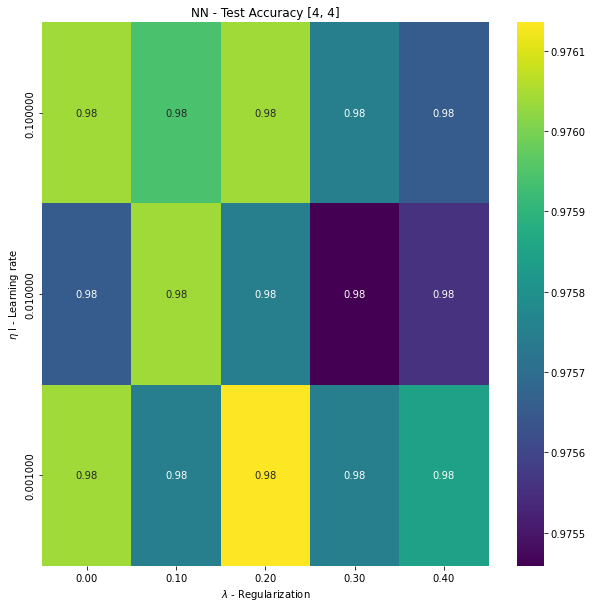

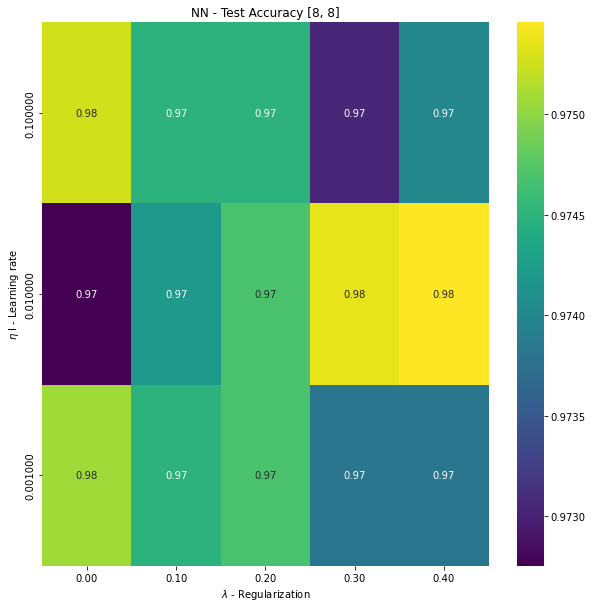

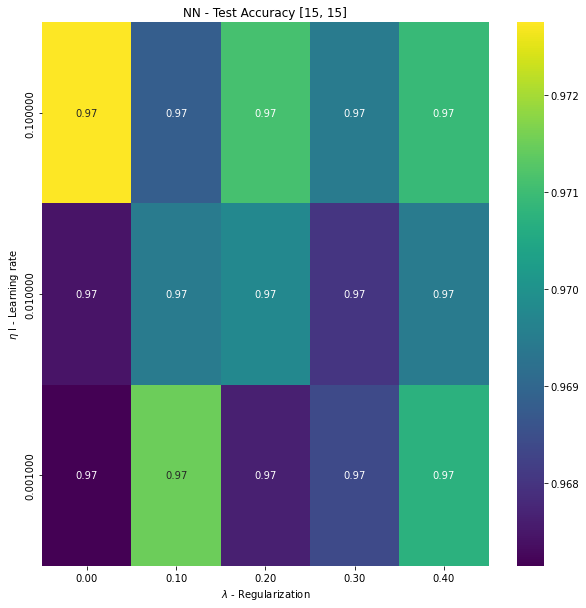

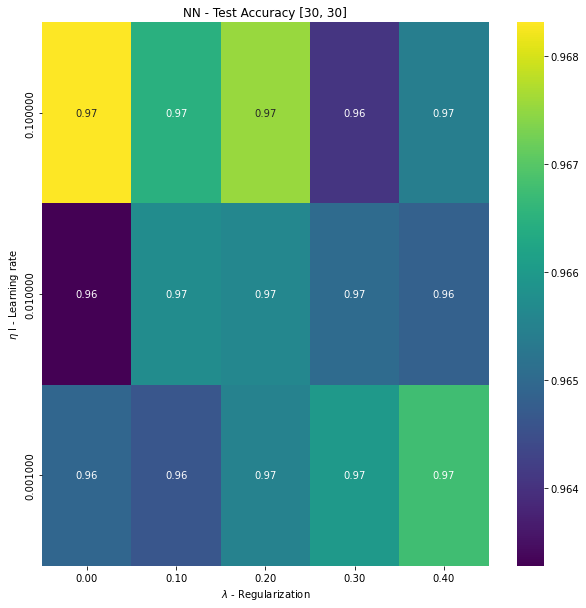

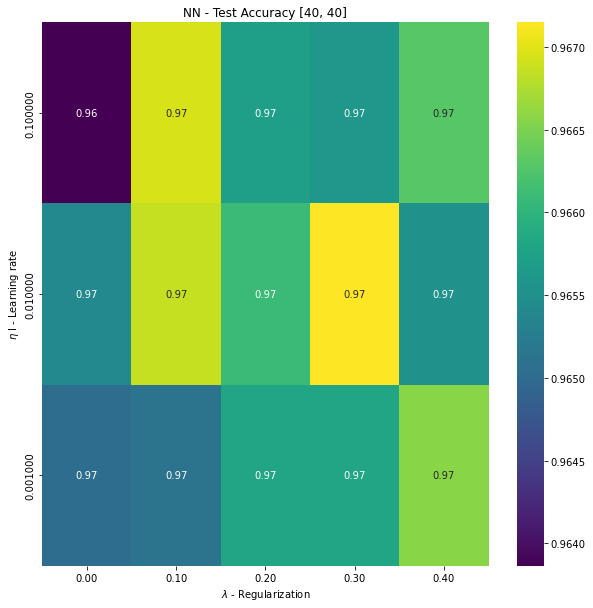

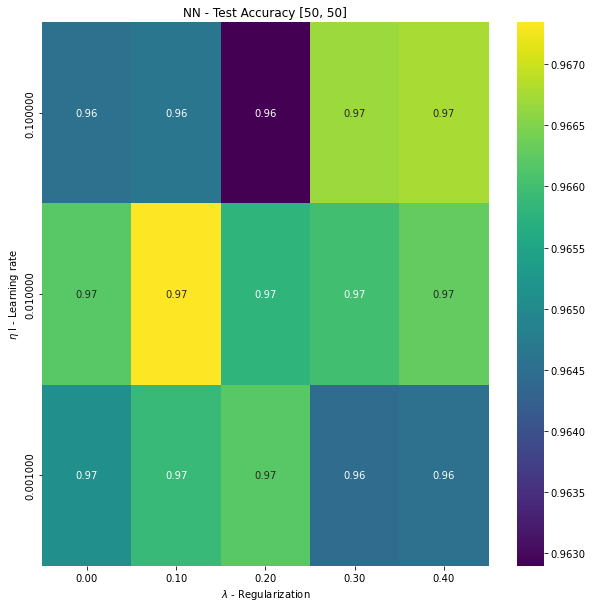

In [79]:
#parameters
learning_rate = [0.1, 0.01, 0.001] #sklearn can handle larger learning rates
regularization = [0, 0.1, 0.2, 0.3, 0.4]
hidden_layer_sizes = [[4, 4], [8, 8], [15, 15], [30, 30], [40, 40], [50, 50]]
k_folds = 5
n_epochs = 20000

onehot = OneHotEncoder(sparse=False)
random_accuracy = np.zeros((len (hidden_layer_sizes), len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((random_accuracy.shape))
test_accuracy_skl = np.zeros((random_accuracy.shape))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

for hidden_l in tqdm.tqdm(range(len(hidden_layer_sizes))):
    for i in range(len(learning_rate)):
        for j in range(len(regularization)):
            R2_test = []
            R2_train = []
            for k in range(k_folds):     
            # extract folds
    
                xy_test = xy_folds[k].copy() # k-th fold is test 
                xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

                x_train = xy_train[:, 0:-1]
                y_train = xy_train[:, -1].reshape(-1, 1)
                x_test = xy_test[:, 0:-1]
                y_test = xy_test[:, -1].reshape(-1, 1)   
            
                y_test_onehot = onehot.fit_transform(y_test)
                y_train_onehot = onehot.fit_transform(y_train)

                dnn = MLPClassifier(learning_rate_init=learning_rate[i], 
                                    alpha=regularization[j], 
                                    max_iter=n_epochs, 
                                    activation='relu',
                                    solver='lbfgs',
                                    verbose = False,
                                    hidden_layer_sizes=hidden_layer_sizes[hidden_l])
                
                dnn.fit(x_train, y_train_onehot)
                dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #select max likelihood
                dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
                if not np.isnan(np.sum(dnn_ypred_test)): 
                    R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
                if not np.isnan(np.sum(dnn_ypred_train)):
                    R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

            train_accuracy_skl[hidden_l, i, j] = np.mean(R2_train)
            test_accuracy_skl[hidden_l, i, j] = np.mean(R2_test)


for hidden_l in range(len(hidden_layer_sizes)):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_accuracy_skl[hidden_l, :, :], annot=True, ax=ax, cmap="viridis")
    ax.set_title("NN - Test Accuracy " + str(hidden_layer_sizes[hidden_l]))
    ax.set_ylabel("$\eta$ l - Learning rate")
    ax.set_xlabel("$\lambda$ - Regularization")
    ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
    ax.set_yticklabels(["{0:0.6f}".format(i) for i in learning_rate] )
    plt.show()

In [19]:
accuracy_score(y_test, np.zeros(y_test.shape) )

0.9739130434782609

### Testing NN logistic - Grid search for good parameters

 33%|▎| 2/6 [34:48<1:18:26, 1176.60s/it/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to c

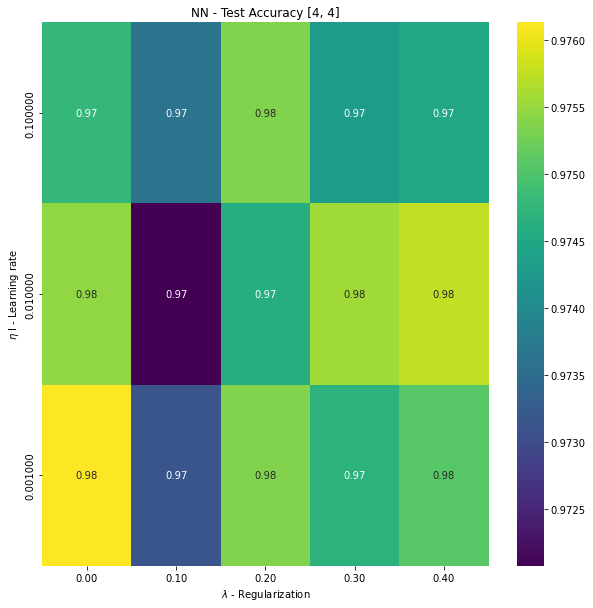

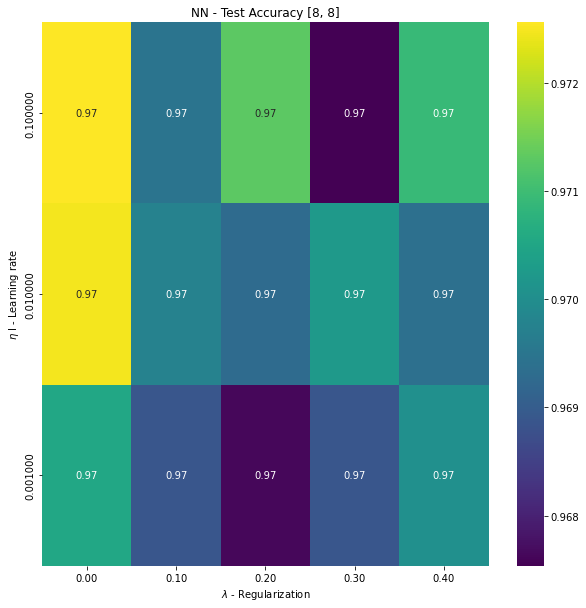

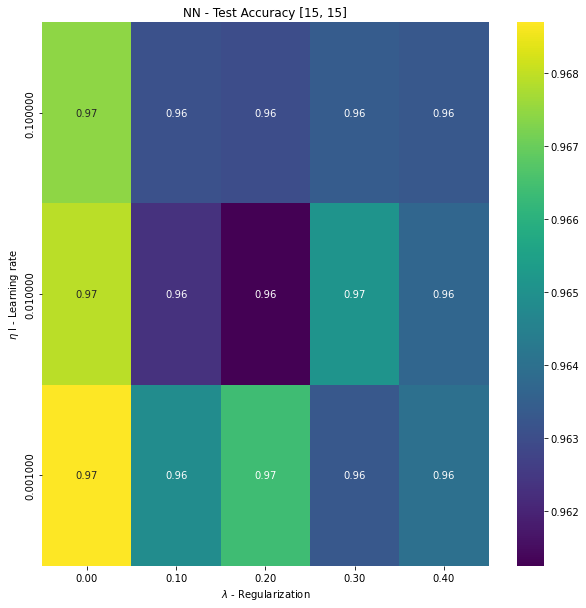

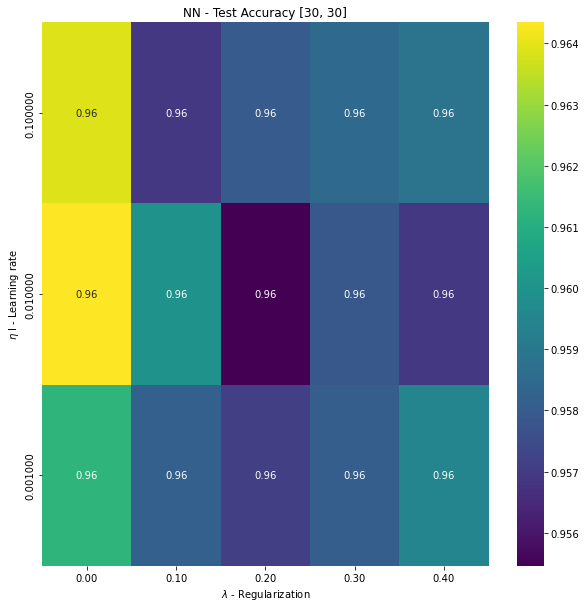

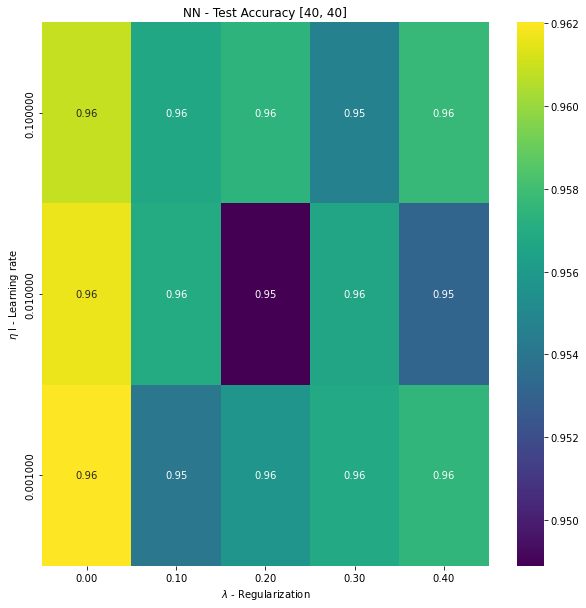

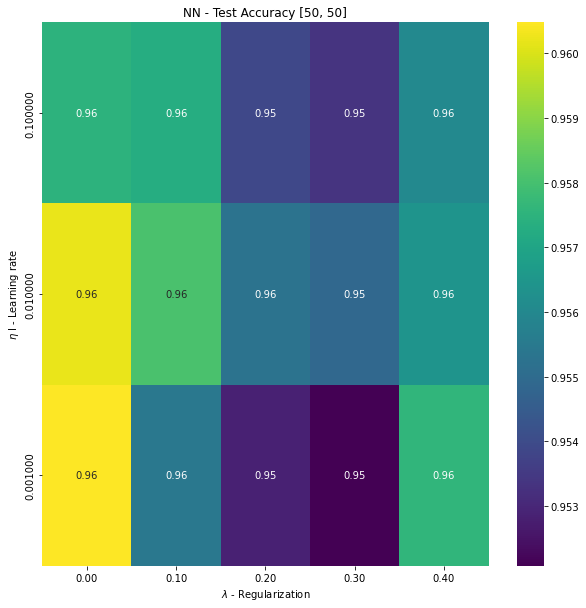

In [80]:
#parameters
learning_rate = [0.1, 0.01, 0.001] #sklearn can handle larger learning rates
regularization = [0, 0.1, 0.2, 0.3, 0.4]
hidden_layer_sizes = [[4, 4], [8, 8], [15, 15], [30, 30], [40, 40], [50, 50]]
k_folds = 5
n_epochs = 20000

onehot = OneHotEncoder(sparse=False)
random_accuracy = np.zeros((len (hidden_layer_sizes), len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((random_accuracy.shape))
test_accuracy_skl = np.zeros((random_accuracy.shape))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

for hidden_l in tqdm.tqdm(range(len(hidden_layer_sizes))):
    for i in range(len(learning_rate)):
        for j in range(len(regularization)):
            R2_test = []
            R2_train = []
            for k in range(k_folds):     
            # extract folds
    
                xy_test = xy_folds[k].copy() # k-th fold is test 
                xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

                x_train = xy_train[:, 0:-1]
                y_train = xy_train[:, -1].reshape(-1, 1)
                x_test = xy_test[:, 0:-1]
                y_test = xy_test[:, -1].reshape(-1, 1)   
            
                y_test_onehot = onehot.fit_transform(y_test)
                y_train_onehot = onehot.fit_transform(y_train)

                dnn = MLPClassifier(learning_rate_init=learning_rate[i], 
                                    alpha=regularization[j], 
                                    max_iter=n_epochs, 
                                    activation='logistic',
                                    solver='lbfgs',
                                    verbose = False,
                                    hidden_layer_sizes=hidden_layer_sizes[hidden_l])
                
                dnn.fit(x_train, y_train_onehot)
                dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #select max likelihood
                dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
                if not np.isnan(np.sum(dnn_ypred_test)): 
                    R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
                if not np.isnan(np.sum(dnn_ypred_train)):
                    R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

            train_accuracy_skl[hidden_l, i, j] = np.mean(R2_train)
            test_accuracy_skl[hidden_l, i, j] = np.mean(R2_test)


for hidden_l in range(len(hidden_layer_sizes)):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_accuracy_skl[hidden_l, :, :], annot=True, ax=ax, cmap="viridis")
    ax.set_title("NN - Test Accuracy " + str(hidden_layer_sizes[hidden_l]))
    ax.set_ylabel("$\eta$ l - Learning rate")
    ax.set_xlabel("$\lambda$ - Regularization")
    ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
    ax.set_yticklabels(["{0:0.6f}".format(i) for i in learning_rate] )
    plt.show()

### Study and NN prediction on the validation dataset
Here we train the model on the whole train and test dataset. We then use the optimal hyperparamteres found in the  previous analysis to predtict wet and dry periods on the validation dataset. It seems that an architecture that geusses no rain at all have a good accuracy score, and that the results

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


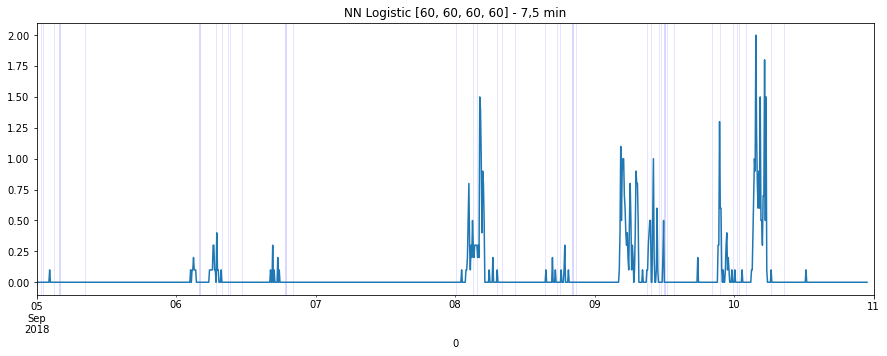

In [20]:
onehot = OneHotEncoder(sparse=False)

# interesting fit
#learning_rate = 0.01 # initial
#regularization = 0
#n_epochs = 20000
#hidden_layer_sizes = [50, 50] #[4, 5]

learning_rate = 0.001 # initial
regularization = 0
n_epochs = 20000
hidden_layer_sizes = [60, 60, 60, 60] #[4, 5]

y_onehot = onehot.fit_transform(y)
n_categories = y_onehot.shape[1]
#dnn = NeuralNetwork(x, y_onehot, n_categories, output_func, eta=learning_rate, 
#                    lmbd=regularization, epochs=n_epochs, batch_size=batch_size, 
#                    activation_func = 'logistic',
#                    hidden_layer_sizes=hidden_layer_sizes)

dnn = MLPClassifier(learning_rate_init=learning_rate, 
                    alpha=regularization, 
                    max_iter=n_epochs, 
                    activation='logistic',
                    solver='lbfgs',
                    verbose = False,
                    hidden_layer_sizes=hidden_layer_sizes)

dnn.fit(x, y_onehot)
dnn_ypred = np.argmax(dnn.predict(x_validation), axis = 1) #de one-hot

#####################################################################

precipitation = pd.DataFrame(np.hstack([t_validation.reshape(-1,1), y_rain_val])).set_index(0)
fig, ax = plt.subplots(figsize = (15, 5))
precipitation.plot(ax=ax)
ax.set_title("NN Logistic " + str(hidden_layer_sizes) + " - 7,5 min")

wet_start = []
wet_end = []
# start and end of wet periodes
for i in range(len(dnn_ypred)):
    # start of wet period
    if dnn_ypred[i - 1] == 0 and dnn_ypred[i] != 0:
        wet_start.append(i)
    # start of dry period
    if dnn_ypred[i] != 0 and dnn_ypred[i + 1] == 0:
        wet_end.append(i)

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(wet_start, wet_end):
    ax.axvspan(t_validation[wet_start_i], t_validation[wet_end_i], color='b', alpha=0.1)

ax.set_xlim(pd.Timestamp('2018-09-05'), pd.Timestamp('2018-09-11'))

leg = plt.legend()

ax.get_legend().remove()

In [18]:
# accuracy score on validation dataset
print("Accuracy score on validation dataset: " + str(accuracy_score(y_validation.ravel(), dnn_ypred ) ))

# Result for saying no rain: 
print("Accuracy score for predicting no rain on validation: "+ str(
    accuracy_score(y_validation.ravel(), np.zeros(y_validation.shape[0]) ) ) )

Accuracy score on validation dataset: 0.9333333333333333
Accuracy score for predicting no rain on validation: 0.946376811594203


In [25]:
from sklearn.linear_model import LogisticRegression
onehot = OneHotEncoder(sparse=False)

regularization = np.array([10000,  10,  5]) #inverse of lambda
k_folds = 5
max_iter = 1000

train_accuracy_lr = np.zeros(len(regularization))
test_accuracy_lr = np.zeros(len(regularization))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

for j in range(len(regularization)):
    R2_test = []
    R2_train = []
    for k in range(k_folds):     
        # extract folds
        xy_test = xy_folds[k].copy() # k-th fold is test 
        xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold
        x_train = xy_train[:, 0:-1]
        y_train = xy_train[:, -1].reshape(-1, 1)
        x_test = xy_test[:, 0:-1]
        y_test = xy_test[:, -1].reshape(-1, 1)   
            
        clf = LogisticRegression(penalty='l2',
                                 C = regularization[j], 
                                 multi_class = 'multinomial', #cross entropy cost function
                                 max_iter = max_iter) 
          
        clf.fit(x_train, y_train.ravel() )
        LR_predict_test = clf.predict(x_test)
        LR_predict_train = clf.predict(x_train)
          
        if not np.isnan(np.sum(LR_predict_test)): 
            R2_test.append( accuracy_score(y_test.ravel(), LR_predict_test.ravel() ))
        if not np.isnan(np.sum(LR_predict_train)):
            R2_train.append(accuracy_score( y_train.ravel(), LR_predict_train.ravel() )) 

    train_accuracy_lr[j] = np.mean(R2_train)
    test_accuracy_lr[j] = np.mean(R2_test)

In [9]:
train_accuracy_lr

array([0.97601449, 0.97601449, 0.97601449])

### Logistic regression prediction on the validation dataset
Here we train the model on the whole train and test dataset. We then use the optimal hyperparamteres found in the  previous analysis to predtict wet and dry periods on the validation dataset. 

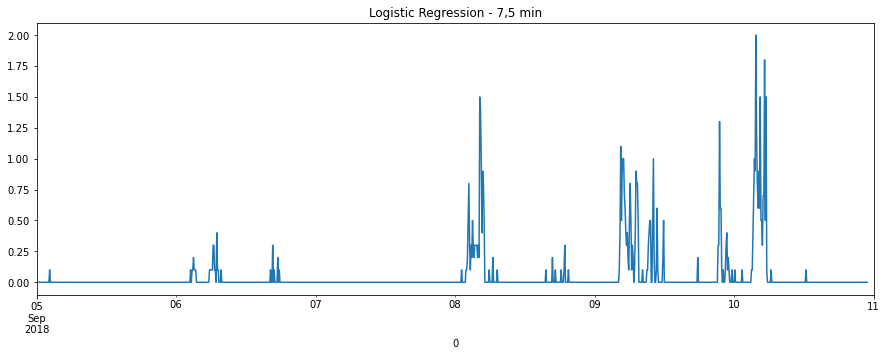

In [29]:
onehot = OneHotEncoder(sparse=False)
batch_size = 64
learning_rate = 0.1 # optimal learning rate
regularization = 10


batch_size = 32
n_epochs = 200

y_onehot = onehot.fit_transform(y)
n_categories = y_onehot.shape[1]

clf = LogisticRegression(penalty='l2',
                         C = regularization, 
                         multi_class = 'multinomial', #cross entropy cost function
                         max_iter = max_iter) 

clf.fit(x, y.ravel())   
LR_predict = clf.predict(x_validation)

precipitation = pd.DataFrame(np.hstack([t_validation.reshape(-1,1), y_rain_val])).set_index(0)
fig, ax = plt.subplots(figsize = (15, 5))
precipitation.plot(ax=ax)
ax.set_title("Logistic Regression - 7,5 min")

wet_start = []
wet_end = []
# start and end of wet periodes
for i in range(len(dnn_ypred)):
    # start of wet period
    if LR_predict[i - 1] == 0 and LR_predict[i] != 0:
        wet_start.append(i)
    # start of dry period
    if LR_predict[i] != 0 and LR_predict[i + 1] == 0:
        wet_end.append(i)

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(wet_start, wet_end):
    ax.axvspan(t_validation[wet_start_i], t_validation[wet_end_i], color='b', alpha=0.1)

ax.set_xlim(pd.Timestamp('2018-09-05'), pd.Timestamp('2018-09-11'))

leg = plt.legend()

ax.get_legend().remove()

In [11]:
# accuracy score on validation dataset
print("Accuracy score on validation dataset: " + str(accuracy_score(y_validation.ravel(), LR_predict ) ))

# Result for saying no rain: 
print("Accuracy score for predicting no rain on validation: "+ str(
    accuracy_score(y_validation.ravel(), np.zeros(y_validation.shape[0]) ) ) )

Accuracy score on validation dataset: 0.946376811594203
Accuracy score for predicting no rain on validation: 0.946376811594203


# Next  - Recurrent Neural network

In [39]:
%matplotlib inline

# Start importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras import optimizers     
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical 

# convert into dataset matrix
def convertToMatrix(data, step):
    X =[]
    for i in range(len(data)-step): # i går gjennom data array utenom de 4 siste som er like
        d=i+step  # ny hver gang, gir et form for "gap"
        X.append(data[i:d,]) # 4 timesteps bakover i tid legges til... 
    return np.array(X) # resultatet er en array med mange små arrays (som er beslekta i tid...)

step = 4
df = pd.DataFrame(x)
values=df.values

split = 0.75
n = values.shape[0]

trainX, testX = values[0:int(n*split), : ], values[int(n*split):n, : ]

# add step elements into train and test
#test = np.vstack([test, np.repeat(test[-1,][np.newaxis], step, axis=0)])
#train = np.vstack([train, np.repeat(train[-1,][np.newaxis], step, axis=0)]) 

#trainX =convertToMatrix(train,step)
#testX =convertToMatrix(test,step)

#y_onehot = onehot.fit_transform(y)

trainY, testY = y[0:int(n*split), : ], y[int(n*split):n, : ]
# til format som RNN trenger?
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
#model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu", return_sequences=True))
model.add(LSTM(units=50, input_shape=(1, trainX.shape[1]), return_sequences=True))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

index = df.index.values
plt.plot(df)
plt.plot(index, predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             14200     
_________________________________________________________________
dense_10 (Dense)             (None, 1, 8)              408       
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)              9         
Total params: 14,617
Trainable params: 14,617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


ValueError: in user code:

    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/erlend/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 20)


In [29]:
convertToMatrix(train,step)

array([[[-29.5, -30. , -30. , ..., -30.5, -31. , -31. ],
        [-30.5, -30. , -30.5, ..., -30.5, -30.5, -30.5],
        [-29.5, -29.5, -29.5, ..., -31. , -31. , -31. ],
        [-30. , -30.5, -30.5, ..., -31.5, -31. , -31.5]],

       [[-30.5, -30. , -30.5, ..., -30.5, -30.5, -30.5],
        [-29.5, -29.5, -29.5, ..., -31. , -31. , -31. ],
        [-30. , -30.5, -30.5, ..., -31.5, -31. , -31.5],
        [-30. , -30. , -31. , ...,   0. , -31. , -31. ]],

       [[-29.5, -29.5, -29.5, ..., -31. , -31. , -31. ],
        [-30. , -30.5, -30.5, ..., -31.5, -31. , -31.5],
        [-30. , -30. , -31. , ...,   0. , -31. , -31. ],
        [-30.5, -31. , -31. , ..., -31. , -31. , -31.5]],

       ...,

       [[-19. , -19. , -19. , ..., -19.5, -19. , -18.5],
        [-26.5, -26. , -26. , ..., -27. , -26. , -25.5],
        [-12. , -12. , -12. , ..., -11.5, -12. , -11.5],
        [-12. , -12. , -12. , ..., -11.5, -12. , -11.5]],

       [[-26.5, -26. , -26. , ..., -27. , -26. , -25.5],
        [-